# Basic Material Features #

Materials are key components of hydrogen transport simulations. They hold the properties like diffusivity, solubility and even thermal properties like thermal conductivity or heat capacity. Read more about the `Materials` class and syntax at __[Materials](https://festim.readthedocs.io/en/v1.0.1/userguide/materials.html)__.

Another helpful feature we show is how to integrate FESTIM with HTM. H-transport-materials (HTM) is a python library for accessing hydrogen transport properties such as diffusivities, solubilities, recombination coefficients, etc. It is an __[open-source project](https://github.com/RemDelaporteMathurin/h-transport-materials)__. and contributions to the database are more than welcome! See the online dashboard __[here](https://htm-dashboard-uan5l4xr6a-od.a.run.app/)__!

Objectives:
* Learn how to define a material for a basic (diffusion only) simulation
* Learn how to use and integrate HTM in FESTIM

## Defining a material in FESTIM ##
First, we set up a 1D mesh:

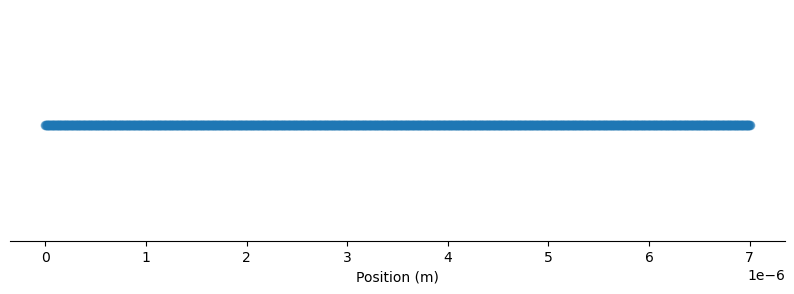

In [1]:
import festim as F
import numpy as np
import matplotlib.pyplot as plt

my_model = F.HydrogenTransportProblem()
my_model.mesh = F.Mesh1D(vertices=np.linspace(0, 7e-6, num=1001))

plt.figure(figsize=(10, 3))
plt.plot(my_model.mesh.vertices, np.zeros_like(my_model.mesh.vertices), marker="o", color="tab:blue", alpha=0.5)
plt.xlabel("Position (m)")
plt.yticks([])
# remove spines
plt.gca().spines[['top', 'right', 'left']].set_visible(False)
plt.show()

Now, we define a material using the diffusion exponential pre-factor $D_0$ and activation energy $E_d$, which is material dependent. For example, let us look at copper, which has $D_0 = 1.11E{-6}$ $m^2/s$ and $E_d = 0.40$ $eV$ (Otsuka).

In [2]:
copper_d0 = 1.11e-6  # m^2/s
copper_ed = 0.4  # eV
mat = F.Material(D_0=copper_d0, E_D=copper_ed)

Finally, we set up the boundary conditions and settings, and then run the steady-state simulation:

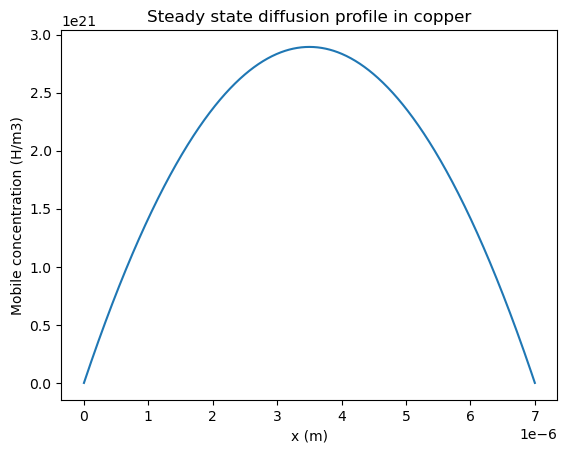

In [3]:
volume_subdomain = F.VolumeSubdomain1D(id=1, borders=[0, 7e-6], material=mat)
boundary_left = F.SurfaceSubdomain1D(id=1, x=0)
boundary_right = F.SurfaceSubdomain1D(id=2, x=7e-6)
my_model.subdomains = [volume_subdomain, boundary_left, boundary_right]
H = F.Species("H")
my_model.species = [H]

my_model.temperature = 300
my_model.boundary_conditions = [
    F.FixedConcentrationBC(subdomain=boundary_left, value=1e15, species=H),
    F.FixedConcentrationBC(subdomain=boundary_right, value=1e15, species=H),
]

my_model.sources = [F.ParticleSource(value=1e20, volume=volume_subdomain, species=H)]
my_model.settings = F.Settings(atol=1e10, rtol=1e-10) 
my_model.settings.transient = False
my_model.settings.stepsize = None

class ProfileExport(F.VolumeQuantity):

    def compute(self):
        profile = self.field.solution.x.array[:].copy()

        self.data.append(profile)

profile = ProfileExport(field=H, volume=volume_subdomain)

my_model.exports = [profile]

my_model.initialise()
my_model.run()

x = my_model.mesh.mesh.geometry.x[:, 0]
data = profile.data[0]
plt.plot(x, data)
plt.xlabel("x (m)")
plt.ylabel("Mobile concentration (H/m3)")
plt.title("Steady state diffusion profile in copper")
plt.show()

## Using the HTM Library ##

First, install HTM by running: 

` pip install h-transport-materials `

Now that HTM is installed, let's look at at the HTM api.

The diffusivities in the HTM database are stored in ` htm.diffusivities `. They can be filtered by material, isotope, author, year with the ` .filter() ` method. 

Let's plot the different diffusivities for tungsten:

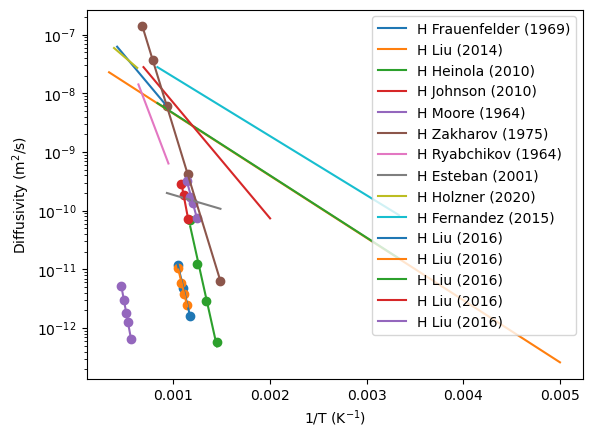

In [4]:
import h_transport_materials as htm

# filter only tungsten and H
diffusivities = htm.diffusivities.filter(material="tungsten").filter(isotope="h")


# plot the properties
htm.plotting.plot(diffusivities)

import matplotlib.pyplot as plt

plt.yscale("log")
plt.ylabel("Diffusivity (m$^2$/s)")
plt.legend()
plt.show()

Now let's take a look at the different solubilities for tungsten:

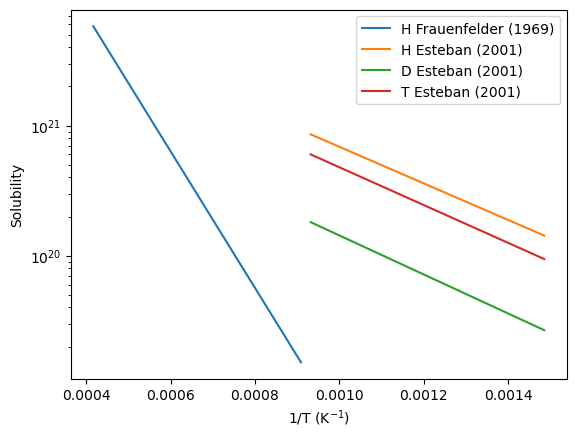

In [5]:
plt.figure()
# filter only tungsten and H
solubilities = htm.solubilities.filter(material="tungsten")

htm.plotting.plot(solubilities)


plt.yscale("log")
plt.ylabel("Solubility")
plt.legend()
plt.show()

## Integrating with FESTIM ##

To use HTM in FESTIM, we should first specify an author to get specific material properties. For example, let's look at tungsten properties from Frauenfelder. We can filter the properties with `.filter(author="frauenfelder")`, obtaining a single `htm.ArrheniusProperty object`:

In [6]:
diffusivities = htm.diffusivities.filter(material="tungsten").filter(isotope="h").filter(author="frauenfelder")
D = diffusivities[0]

print(type(diffusivities))
print(type(D))

<class 'h_transport_materials.properties_group.PropertiesGroup'>
<class 'h_transport_materials.property.Diffusivity'>


A `htm.ArrheniusProperty` object has several useful attributes like `.pre_exp` which holds the pre-exponential factor, `.act_energy` for the activation energy but also `.author` and `.year`:

In [7]:
print(D)


        Author: Frauenfelder
        Material: tungsten
        Year: 1969
        Isotope: H
        Pre-exponential factor: 4.10×10⁻⁷ m²/s
        Activation energy: 3.90×10⁻¹ eV/particle
        


We can also look at the solubility:

In [8]:
S = htm.solubilities.filter(material="tungsten").filter(author="frauenfelder")[0]
print(S)


        Author: Frauenfelder
        Material: tungsten
        Year: 1969
        Isotope: H
        Pre-exponential factor: 8.88×10²³ particle/m³/Pa⁰⋅⁵
        Activation energy: 1.04×10⁰ eV/particle
        


These properties can then be used inside a `FESTIM.Material` object. This is extremely useful to avoid silly copy-pasting mistakes and typos in simulations.

In [9]:
import festim as F

tungsten = F.Material(
    D_0=D.pre_exp.magnitude, E_D=D.act_energy.magnitude,
    K_S_0=S.pre_exp.magnitude, E_K_S=S.act_energy.magnitude
    )

print(tungsten)